In [59]:
%matplotlib inline


# Classification of text documents using sparse features

This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. It will be
automatically downloaded, then cached.


In [60]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

## Configuration options for the analysis



In [70]:
# If True, we use `HashingVectorizer`, otherwise we use a `TfidfVectorizer`
USE_HASHING = False

# Number of features used by `HashingVectorizer`
N_FEATURES = 2**16

# Optional feature selection: either False, or an integer: the number of
# features to select
SELECT_CHI2 = False

## Load data from the training set
Let's load data from the newsgroups dataset which comprises around 18000
newsgroups posts on 20 topics split in two subsets: one for training (or
development) and the other one for testing (or for performance evaluation).



In [71]:
import pandas as pd

categories = [
    '11-1021.00',
    '11-2021.00',
    '11-2022.00',
    '11-3031.02',
    '13-1111.00',
    '13-2051.00',
    '15-1121.00',
    '15-1122.00',
    '15-1132.00',
    '15-1133.00',
    '15-1134.00',
    '15-1142.00',
    '15-1151.00',
    '29-1141.00',
    '31-1014.00',
    '33-3021.06',
    '41-2031.00',
    '43-4051.00',
    '49-3023.02',
    '49-9071.00',
    '53-3032.00'
]

data_train = pd.read_csv('../data/train_df.csv')
data_test = pd.read_csv('../data/test_df.csv')

# order of labels in `target_names` can be different from `categories`
target_names = categories


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.Title)
data_test_size_mb = size_mb(data_test.Title)

print(
    "%d documents - %0.3fMB (training set)" % (len(data_train.Title), data_train_size_mb)
)
print("%d documents - %0.3fMB (test set)" % (len(data_test.Title), data_test_size_mb))
print("%d categories" % len(target_names))

12098 documents - 0.408MB (training set)
3025 documents - 0.102MB (test set)
21 categories


## Vectorize the training and test data

split a training set and a test set



In [72]:
y_train, y_test = data_train.Code, data_test.Code

Extracting features from the training data using a sparse vectorizer



In [73]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

t0 = time()

if USE_HASHING:
    vectorizer = HashingVectorizer(
        stop_words="english", alternate_sign=False, n_features=N_FEATURES
    )
    X_train = vectorizer.transform(data_train.Title)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
    X_train = vectorizer.fit_transform(data_train.Title)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)

done in 0.094833s at 4.298MB/s
n_samples: 12098, n_features: 4229


Extracting features from the test data using the same vectorizer



In [74]:
t0 = time()
X_test = vectorizer.transform(data_test.Title)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)

done in 0.024329s at 4.211MB/s
n_samples: 3025, n_features: 4229


mapping from integer feature name to original token string



In [75]:
if USE_HASHING:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names_out()

Keeping only the best features



In [76]:
from sklearn.feature_selection import SelectKBest, chi2

if SELECT_CHI2:
    print("Extracting %d best features by a chi-squared test" % SELECT_CHI2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=SELECT_CHI2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names is not None:
        # keep selected feature names
        feature_names = feature_names[ch2.get_support()]
    print("done in %fs" % (time() - t0))
    print()

## Benchmark classifiers

First we define small benchmarking utilities



In [77]:
import numpy as np
from sklearn import metrics
from sklearn.utils.extmath import density


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


def benchmark(clf):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, "coef_"):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))

    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split("(")[0]
    return clf_descr, score, train_time, test_time

We now train and test the datasets with 15 different classification
models and get performance results for each model.



In [78]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier


results = []
for clf, name in (
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (Perceptron(max_iter=50), "Perceptron"),
    (PassiveAggressiveClassifier(max_iter=50), "Passive-Aggressive"),
    (KNeighborsClassifier(n_neighbors=10), "kNN"),
    (RandomForestClassifier(), "Random forest"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print("=" * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty=penalty)))

# Train SGD with Elastic Net penalty
print("=" * 80)
print("Elastic-Net penalty")
results.append(
    benchmark(SGDClassifier(alpha=0.0001, max_iter=50, penalty="elasticnet"))
)

# Train NearestCentroid without threshold
print("=" * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print("=" * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=0.01)))
results.append(benchmark(BernoulliNB(alpha=0.01)))
results.append(benchmark(ComplementNB(alpha=0.1)))

print("=" * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(
    benchmark(
        Pipeline(
            [
                (
                    "feature_selection",
                    SelectFromModel(LinearSVC(penalty="l1", dual=False, tol=1e-3)),
                ),
                ("classification", LinearSVC(penalty="l2")),
            ]
        )
    )
)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


/home/transcend/code/BANGKOK/nrich/nrich-test-assignment/venv/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:830: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 0.511s
test time:  0.001s
accuracy:   0.454
dimensionality: 4229
density: 1.000000
top 10 keywords per class:
11-1021.00: geo refurb outbound merchandiser initiative attorney ann store qp...
11-2021.00: alliances sustainable campaign art capture channel product brand ...
11-2022.00: underpayments immediately brands american cx pharmaceutical smb c...
11-3031.02: vendor controller recognition outsourcing banker fc audit account...
13-1111.00: acquistion effectiveness acquisition facets accenture mai acc loc...
13-2051.00: reconciliation storeroom instuctor financial cont treasury budget...
15-1121.00: fighter order lifecycle oversight ppbe maritime mss appsw linguis...
15-1122.00: isso intrusion mcafee malware librarian fingerprinting splunk aut...
15-1132.00: atlassian cucm netsuite hot salesforce ui tbma software trust devops
15-1133.00: secureview ground missions gpu combat payload optical embedded da...
15-1134.00: workers restful jbpm sofware brava osisoft rational mvc 

train time: 0.249s
test time:  0.001s
accuracy:   0.400
dimensionality: 4229
density: 0.615016
top 10 keywords per class:
11-1021.00: geo govcon bowdoin cla assitant ann models copper wastewater opera
11-2021.00: accessories solidfire infra paas speaking mrf lewin hhonors servi...
11-2022.00: institutions enforcement resilience insight protective marketplac...
11-3031.02: merchandise pd swim rotational governanc weekends freight prem if...
13-1111.00: fss available excellence forecasting cqi institutional interfaces...
13-2051.00: dss frc cta verification technlgst ccmr rosslyn fmx cisa faitas
15-1121.00: hcp lifecycle prncpl improvised doc ilss overall maritime biztalk ww
15-1122.00: dlp families ite isse reviewer poa intell librarian intrusion and...
15-1132.00: dart freelancer bilinqual hot cop publisher ibm dwbi lims suicide
15-1133.00: machine architectures measure fcs ecosystem cxp frontend battle m...
15-1134.00: mvc pdx ssbu bike opportunity qc drupal restful backbonejs lob
15-

train time: 9.834s
test time:  0.149s
accuracy:   0.454
classification report:
              precision    recall  f1-score   support

  11-1021.00       0.26      0.33      0.30       147
  11-2021.00       0.41      0.47      0.44       195
  11-2022.00       0.39      0.34      0.37       119
  11-3031.02       0.58      0.46      0.52       108
  13-1111.00       0.36      0.37      0.36       173
  13-2051.00       0.35      0.26      0.30        72
  15-1121.00       0.34      0.20      0.25       110
  15-1122.00       0.58      0.57      0.58       263
  15-1132.00       0.47      0.55      0.51       270
  15-1133.00       0.33      0.33      0.33       246
  15-1134.00       0.28      0.14      0.19        49
  15-1142.00       0.53      0.57      0.55       270
  15-1151.00       0.23      0.18      0.20        89
  29-1141.00       0.67      0.82      0.74       297
  31-1014.00       0.43      0.14      0.22        70
  33-3021.06       0.42      0.53      0.47       148
  

train time: 0.156s
test time:  0.001s
accuracy:   0.456
dimensionality: 4229
density: 0.308944
top 10 keywords per class:
11-1021.00: louis initiative attorney outbound shopping qpm goods party store...
11-2021.00: campaign iot hhonors alliances art product channel capture brand ...
11-2022.00: immediately intl major pharmaceutical craft account smb od prime ...
11-3031.02: controller hrs accounting sec fc recognition audit accountant hou...
13-1111.00: change acquistion facets acc mlt effectiveness ocm adoption accen...
13-2051.00: economic investments isrm cont alm fp budget fpa treasury cpic
15-1121.00: enabled gl order maritime fighter strike mss appsw linguist epic
15-1122.00: isso cnd fingerprinting ids malware soc splunk authorization assu...
15-1132.00: config trust netsuite developer hot salesforce android ui devops ...
15-1133.00: missions satellite payload ground spacecraft spectrum optical com...
15-1134.00: script aem jbpm sofware brava rational osisoft mvc drupal sharepoi

train time: 0.157s
test time:  0.001s
accuracy:   0.400
dimensionality: 4229
density: 0.019536
top 10 keywords per class:
11-1021.00: goods outbound models store payer qpm shopping cabin party honduras
11-2021.00: raceway consumer stewardship alliances snacks capture art channel...
11-2022.00: snr reagan economics sheraton intl prepaid smb broad specialitst ...
11-3031.02: mc transactions sec recognition audit dealer fc accountant hours tax
13-1111.00: acc acquistion jcid capability facets commissions accenture mba a...
13-2051.00: nextlink fp budget alm provost fpa treasury cta sow cpic
15-1121.00: jopes maritime gl order azeri ast appsw oversight linguist epic
15-1122.00: ids isso fingerprinting fisma authorization soc malware splunk as...
15-1132.00: android salesforce dwbi migration ui devops adobe software hot trust
15-1133.00: ground spectrum payload satellite optical combat embedded dasd mk...
15-1134.00: js web developer workers ability mvc ssbu react sharepoint drupal
15-1142.

              precision    recall  f1-score   support

  11-1021.00       0.26      0.25      0.26       147
  11-2021.00       0.41      0.43      0.42       195
  11-2022.00       0.39      0.33      0.36       119
  11-3031.02       0.46      0.49      0.48       108
  13-1111.00       0.30      0.37      0.33       173
  13-2051.00       0.42      0.28      0.33        72
  15-1121.00       0.35      0.22      0.27       110
  15-1122.00       0.55      0.58      0.56       263
  15-1132.00       0.46      0.57      0.51       270
  15-1133.00       0.35      0.31      0.33       246
  15-1134.00       0.38      0.18      0.25        49
  15-1142.00       0.54      0.59      0.56       270
  15-1151.00       0.32      0.25      0.28        89
  29-1141.00       0.69      0.81      0.74       297
  31-1014.00       0.35      0.20      0.25        70
  33-3021.06       0.52      0.53      0.53       148
  41-2031.00       0.44      0.47      0.45       109
  43-4051.00       0.30    

train time: 1.058s
test time:  0.002s
accuracy:   0.455
classification report:
              precision    recall  f1-score   support

  11-1021.00       0.25      0.27      0.26       147
  11-2021.00       0.43      0.43      0.43       195
  11-2022.00       0.39      0.35      0.37       119
  11-3031.02       0.47      0.45      0.46       108
  13-1111.00       0.32      0.35      0.34       173
  13-2051.00       0.40      0.38      0.39        72
  15-1121.00       0.32      0.20      0.25       110
  15-1122.00       0.60      0.57      0.58       263
  15-1132.00       0.49      0.56      0.52       270
  15-1133.00       0.32      0.31      0.32       246
  15-1134.00       0.41      0.27      0.32        49
  15-1142.00       0.52      0.54      0.53       270
  15-1151.00       0.27      0.22      0.25        89
  29-1141.00       0.70      0.82      0.76       297
  31-1014.00       0.31      0.21      0.25        70
  33-3021.06       0.49      0.59      0.54       148
  

## Add plots
The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.



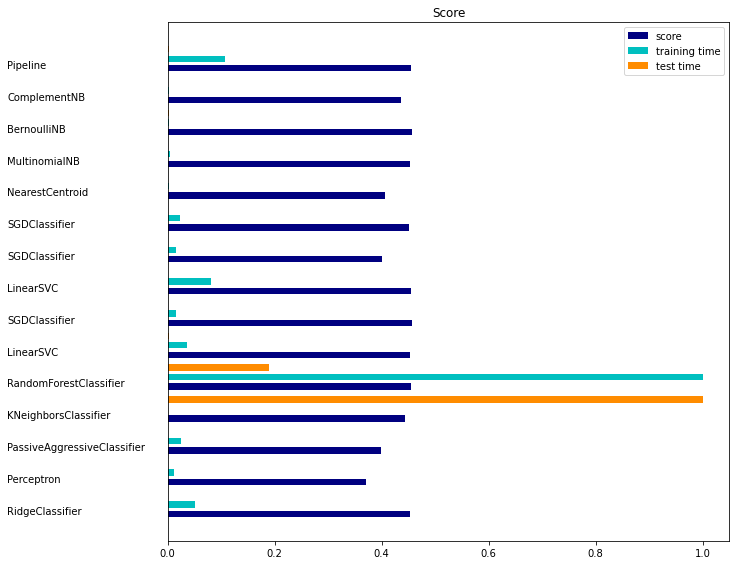

In [79]:
import matplotlib.pyplot as plt

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, 0.2, label="score", color="navy")
plt.barh(indices + 0.3, training_time, 0.2, label="training time", color="c")
plt.barh(indices + 0.6, test_time, 0.2, label="test time", color="darkorange")
plt.yticks(())
plt.legend(loc="best")
plt.subplots_adjust(left=0.25)
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(bottom=0.05)

for i, c in zip(indices, clf_names):
    plt.text(-0.3, i, c)

plt.show()